In [1]:
from state.MainMutGenState import MainState, TpByAgent
from langgraph.graph import START, StateGraph, END
from langgraph.constants import Send
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from modules.SemanticSearch import SemanticSearch

from schemas.mutgen_output import MutationGenerated
from prompts.MutgenAgentPrompt import MUTGEN_SYS, MUTATION_REQUEST

import pandas as pd
import time
from typing import TypedDict
from IPython.display import Image, display
from dotenv import load_dotenv, find_dotenv
import os 

In [2]:
_ = load_dotenv(find_dotenv())

api_openai = os.getenv('OPENAI_API_KEY')
if api_openai:
    print('OpenAI API loaded.')
else:
    print('missing api key: OPEN_API_KEY')

llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0.0
    )

OpenAI API loaded.


In [3]:
retriever = SemanticSearch()
MutGenAI = llm.with_structured_output(MutationGenerated)

In [4]:
def process_data_cluster(state: MainState):
    cluster_path = state["cluster_url"]
    cluster_id = state["cluster"]
    df = pd.read_csv(cluster_path)
    list_obj_train_ref = retriever.collect_batch(df)
    df["gumtree_train_ref"] = list_obj_train_ref
    print("Finalizado batch dos fixes!")
    try:
        final_result_df = pd.read_csv(f"results_{cluster_id}_from_attempt1.csv")
    except:
        final_result_df = pd.DataFrame()
    return {"dataframe": df, "total_requests_from_df": len(df), "final_result_df": final_result_df}
    # return {"dataframe": df, "total_requests_from_df": 10, "final_result_df": final_result_df}

In [5]:
def split_data_process_for_batch(state: MainState):
    if state["gpt_response"]:
        final_result_df = state["final_result_df"]
        cluster_id = state["cluster"]
        list_of_pydantic_objects = state["gpt_response"]
        results_as_dicts = [response.model_dump() for response in list_of_pydantic_objects]
        results_df = pd.DataFrame(results_as_dicts)
        updated_df = pd.concat([final_result_df, results_df], ignore_index=True)

        output_path = f"results_{cluster_id}_from_attempt1.csv"
        updated_df.to_csv(output_path, sep=',', index=False)

    df = state["dataframe"]
    offset = state["current_offset"]
    size = 10
    total_prompts = state["total_requests_from_df"]
    start_index = offset + size
    limit_index = min(start_index, total_prompts)
    
    sliced_df = df.iloc[offset:limit_index]
    print(f"Leva de {offset} ate {start_index} do total de {total_prompts}")
    return {
        "sliced_for_batch": sliced_df, 
        "current_offset": limit_index     
        }

In [6]:
def async_send_conditional(state: MainState):
    async_list = []
    df_sliced = state["sliced_for_batch"]
    for _, row in df_sliced.iterrows():
        async_list.append(Send("Run MutGen", {"tp_request": row}))
    return async_list

In [7]:
def mutgen_agent(state: MainState):
    row_from_df = state["tp_request"]
    train_data_ref = row_from_df.gumtree_train_ref
    fixed_train_data = train_data_ref["fixed_train"]
    buggy_train_data = train_data_ref["buggy_train"]
    mutation_operators = train_data_ref["gumtree_diff"]
    input_fixed_code = row_from_df.fixed
    
    mutation_generation_request = MUTATION_REQUEST.format(
        ref_fixed_example = fixed_train_data,
        mutation_operators_list = mutation_operators,
        ref_buggy_example = buggy_train_data,
        input_fixed_code = input_fixed_code)
    mut_gen_dict = MutGenAI.invoke([SystemMessage(MUTGEN_SYS), HumanMessage(mutation_generation_request)])
    mutant_generated = mut_gen_dict.mutant

    final_response = TpByAgent(fixed_code = input_fixed_code, 
                               buggy_code = row_from_df.buggy, 
                               gumtree_baseline = mutation_operators, 
                               line_in_dataset = row_from_df.line_id_tp_dataset, 
                               mutant_version = mutant_generated)
    return {"gpt_response": [final_response]}

In [8]:
def loop_batch_conditional(state:MainState):
    offset = state["current_offset"]
    total_requests = state["total_requests_from_df"]
    if offset >= total_requests:
        return "Save DF"
    return "Batch Slicing"

In [9]:
def save_dataframe(state: MainState):
    """
    Pega a lista de objetos Pydantic do estado, converte para um DataFrame
    e salva em um arquivo CSV.
    """
    cluster_id = state["cluster"]
    list_of_pydantic_objects = state["gpt_response"]

    if not list_of_pydantic_objects:
        print("Nenhum resultado para salvar.")
        return {}

    final_result_df = state["final_result_df"]
    results_as_dicts = [response.model_dump() for response in list_of_pydantic_objects]
    results_df = pd.DataFrame(results_as_dicts)
    updated_df = pd.concat([final_result_df, results_df], ignore_index=True)

    output_path = f"results_{cluster_id}_from_attempt1.csv"
    updated_df.to_csv(output_path, sep=',', index=False)
    
    print(f"Resultados salvos com sucesso em {output_path}")

    return {"pd.DataFrame": updated_df}

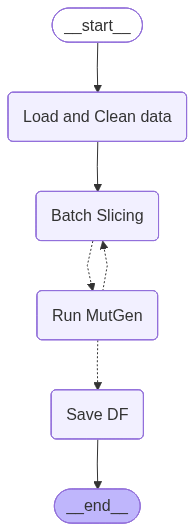

In [10]:
builder = StateGraph(MainState)

builder.add_node("Load and Clean data", process_data_cluster)
builder.add_node("Batch Slicing", split_data_process_for_batch)
builder.add_node("Run MutGen", mutgen_agent)
builder.add_node("Save DF", save_dataframe)

builder.add_edge(START, "Load and Clean data")
builder.add_edge("Load and Clean data", "Batch Slicing")
builder.add_conditional_edges("Batch Slicing", async_send_conditional, ["Run MutGen"])

builder.add_conditional_edges("Run MutGen", 
                              loop_batch_conditional, 
                              {
                                  "Save DF": "Save DF",
                                  "Batch Slicing": "Batch Slicing"
                              })
builder.add_edge("Save DF", END)

graph_execute = builder.compile()
display(Image(graph_execute.get_graph(xray=True).draw_mermaid_png()))

In [11]:
init_input = {
    "cluster": "C5",
    "cluster_url": "datasets_csv/dataset_C5_clean.csv",
    "current_offset": 0 
}

config = {"recursion_limit": 2500}
inicio = time.perf_counter()
messages = graph_execute.invoke(init_input, config)
final = time.perf_counter()

print(f"tempo de inicio {inicio}, e tempo de final {final}")

Finalizado batch dos fixes!
Leva de 0 ate 10 do total de 803
Leva de 10 ate 20 do total de 803
Leva de 20 ate 30 do total de 803
Leva de 30 ate 40 do total de 803
Leva de 40 ate 50 do total de 803
Leva de 50 ate 60 do total de 803
Leva de 60 ate 70 do total de 803
Leva de 70 ate 80 do total de 803
Leva de 80 ate 90 do total de 803
Leva de 90 ate 100 do total de 803
Leva de 100 ate 110 do total de 803
Leva de 110 ate 120 do total de 803
Leva de 120 ate 130 do total de 803
Leva de 130 ate 140 do total de 803
Leva de 140 ate 150 do total de 803
Leva de 150 ate 160 do total de 803
Leva de 160 ate 170 do total de 803
Leva de 170 ate 180 do total de 803
Leva de 180 ate 190 do total de 803
Leva de 190 ate 200 do total de 803
Leva de 200 ate 210 do total de 803
Leva de 210 ate 220 do total de 803
Leva de 220 ate 230 do total de 803
Leva de 230 ate 240 do total de 803
Leva de 240 ate 250 do total de 803
Leva de 250 ate 260 do total de 803
Leva de 260 ate 270 do total de 803
Leva de 270 ate 280 

In [ ]:
dataframe_train = messages["dataframe"]


In [ ]:
dataframe_train.iloc[0].gumtree_train_ref["fixed_train"]

In [ ]:
df= pd.read_csv("results_C2_from_attempt1.csv")

In [ ]:
df

In [ ]:
i = 10
fixed_input = df["fixed_code"].iloc[i]
train_fixed = dataframe_train.iloc[i].gumtree_train_ref["fixed_train"]
print(f"Fixed_input: \n {fixed_input}")
print(f"TRAIN_fixed: \n {train_fixed}")